In [1]:
# https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
train = pd.read_csv('data/train.csv')
train = train.dropna(axis=1, how='all')

test = pd.read_csv('data/test.csv')
test = test.dropna(axis=1, how='all')

data = pd.date_range('10/1/2012', periods=len(train) + len(test), freq='d')


train["Day"] = data[:len(train)]
test["Day"] = data[len(train):]

y = pd.concat([train, test])
# y = y[["Day","sessions"]]
y.index = y.Day
y = y.drop('Day', 1)
y.head()

,sessions
Day,
2012-10-01,1339
2012-10-02,1462
2012-10-03,1702
2012-10-04,1656
2012-10-05,1439


In [3]:
# The 'MS' string groups the data in buckets by start of the month
# y = y.resample('W-MON').mean()

print(y.isnull().sum())

# The term bfill means that we use the value before filling in missing values
y = y.fillna(y.bfill())

print(y)

sessions    0
dtype: int64
            sessions
Day                 
2012-10-01      1339
2012-10-02      1462
2012-10-03      1702
2012-10-04      1656
2012-10-05      1439
2012-10-06      1208
2012-10-07      1613
2012-10-08      1935
2012-10-09      1964
2012-10-10      2003
2012-10-11      2023
2012-10-12      1559
2012-10-13      1274
2012-10-14      1805
2012-10-15      2051
2012-10-16      2024
2012-10-17      2049
2012-10-18      1998
2012-10-19      1441
2012-10-20      1257
2012-10-21      1559
2012-10-22      1643
2012-10-23      1464
2012-10-24      1521
2012-10-25      1576
2012-10-26      1381
2012-10-27      1372
2012-10-28      1610
2012-10-29      1926
2012-10-30      2018
...              ...
2014-02-13      1808
2014-02-14      1454
2014-02-15      1393
2014-02-16      1733
2014-02-17      1944
2014-02-18      1911
2014-02-19      1804
2014-02-20      1525
2014-02-21       573
2014-02-22       576
2014-02-23       740
2014-02-24       760
2014-02-25       784
2014-02

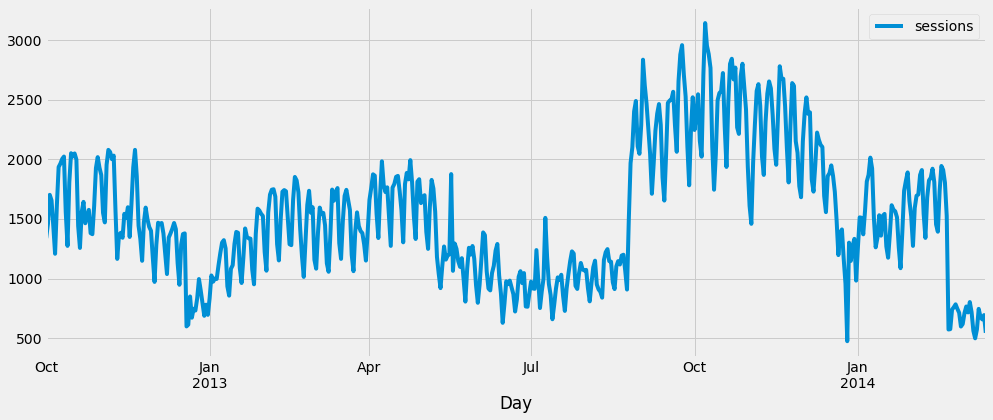

In [4]:
y.plot(figsize=(15, 6))
plt.show()

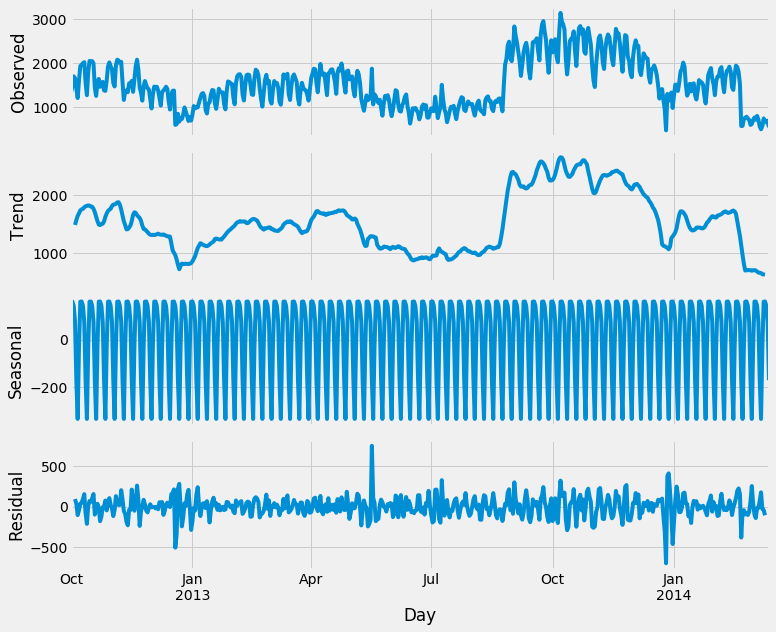

In [5]:
# Change default size of figures
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [6]:
# ARIMA TIME
p = d = q = range(2)

# List of all possible combinations of p,d,q
pdq = list(itertools.product(p,d,q))

#Generate all different combinations of seasonal p, d, and q 
seasonal_pdq = [(x[0], x[1], x[2], 365) for x in list(itertools.product(p,d,q))]


print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

# So ARIMA can have different parameters for non-seasonal vs seasonal 
# components that combine to make better predictions


Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 365)
SARIMAX: (0, 0, 1) x (0, 1, 0, 365)
SARIMAX: (0, 1, 0) x (0, 1, 1, 365)
SARIMAX: (0, 1, 0) x (1, 0, 0, 365)


In [7]:
warnings.filterwarnings('ignore')

solutions = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order = param,
                                            seasonal_order = param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
            results = mod.fit()
            
#             pred = results.get_prediction(start=pd.to_datetime("2014-02-13"),dynamic=True)

            
            
#             y_forecasted = np.array(np.matrix(pred.predicted_mean))
#             y_truth = y[-30:].values


#             err = error(y_truth[:,0], y_forecasted[0])
            
            solutions.append((param, param_seasonal, results.aic()))
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, err))
            
        except:
            continue
            
solutions = sorted(solutions, key=lambda x: x[2])
print(solutions[0])
order, seasonal_order, _ = solutions[0]

IndexError: list index out of range

In [ ]:
# (1,1,1) x (1,1,1,12) is the lowest AIC, so we go with that
# AIC is related to complexity of model and error (lower the better)

mod = sm.tsa.statespace.SARIMAX(y,
                               order=order,
                               seasonal_order=seasonal_order,
                               enforce_stationarity=False,
                               enforce_invertibility=False)
results = mod.fit()
results.summary().tables[1]


In [ ]:
results.plot_diagnostics(figsize=(15, 12))
# Concern is that model is normally distributed/uncorrelated
plt.show()

In [ ]:
pred = results.get_prediction(start=pd.to_datetime("2014-02-13"),dynamic=True)
pred_ci = pred.conf_int()

In [ ]:
ax = y.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead forecast', alpha=.7)

ax.fill_between(pred_ci.index,
               pred_ci.iloc[:, 0],
               pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Sessions')
plt.legend()
plt.show()

In [ ]:
y_forecasted = np.array(np.matrix(pred.predicted_mean))
y_truth = y[-30:].values


def error(expected, predicted):
    
    d = 0
    for e, p in zip(list(expected), list(predicted)):
        d += abs(e - p) / e
        
    return d * 100

# Compute the mean square error
err = error(y_truth[:,0], y_forecasted[0])
print('The Error of our forecasts is {}'.format(err))

In [ ]:
np.array(np.matrix(y_forecasted)).shape, y_truth.shape

In [ ]:
y_truth[:,0] - y_forecasted[0]

In [ ]:
y_truth

In [ ]:
from fbprophet import Prophet

In [ ]:
y.head()

In [ ]:
y['ds'] = y.index
y = y.rename(columns={'sessions':'y'})
y.head()

In [ ]:
ax = y.set_index('ds').plot(figsize=(12,8))
ax.set_ylabel('Sessions')
ax.set_xlabel('Date')

plt.show()

In [ ]:
# Set conf-int to 95%
model = Prophet(interval_width=0.95)

model.fit(y)

In [ ]:
future_dates = model.make_future_dataframe(periods=30, freq='d')
future_dates.tail()

In [ ]:
forecast = model.predict(future_dates)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

In [ ]:
model.plot(forecast, uncertainty=True)

In [ ]:
model.plot_components(forecast)